In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

**Used dataset**

https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb

In [2]:
df_train_copy = pd.read_table('Dataset/Dataset/train_data.txt', sep=":::", names=['srno', 'movie_name', 'genre', 'plot']).drop(columns=['srno'])

df_sol = pd.read_table('Dataset/Dataset/test_data_solution.txt', sep=":::", names=['srno', 'movie_name', "genre", 'plot']).drop(columns=['srno'])

df_test_half = pd.read_table('Dataset/Dataset/test_data.txt', sep=":::", names=['srno', 'movie_name', 'plot']).drop(columns=['srno'])
df_test = pd.merge(df_test_half, df_sol[['movie_name', 'genre']], on='movie_name', how='left')

C:\Users\Aditya Lohia\AppData\Local\Temp\ipykernel_14672\2301635854.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train_copy = pd.read_table('Dataset/Dataset/train_data.txt', sep=":::", names=['srno', 'movie_name', 'genre', 'plot']).drop(columns=['srno'])
C:\Users\Aditya Lohia\AppData\Local\Temp\ipykernel_14672\2301635854.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_sol = pd.read_table('Dataset/Dataset/test_data_solution.txt', sep=":::", names=['srno', 'movie_name', "genre", 'plot']).drop(columns=['srno'])
C:\Users\Aditya Lohia\AppData\Local\Temp\ipykernel_14672\2301635854.py:5: Parse

In [3]:
df_train = df_train_copy.iloc[:54200].copy()

In [4]:
df_train.head(1)

,movie_name,genre,plot
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...


In [5]:
df_test.head(1)

,movie_name,plot,genre
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",thriller


In [6]:
df_sol.head(1)

,movie_name,genre,plot
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."


In [7]:
df_train.shape, df_test.shape, df_sol.shape

((54200, 3), (54200, 3), (54200, 3))

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movie_name  54200 non-null  object
 1   genre       54200 non-null  object
 2   plot        54200 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [9]:
df_train.describe()

,movie_name,genre,plot
count,54200,54200,54200
unique,54200,27,54072
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13611,12


In [10]:
print(df_train.duplicated().sum(), 
df_test.duplicated().sum(),
df_sol.duplicated().sum())

0 0 0


In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
# `r''` : means to not interpret '\' as escape character
# \S+ : means if the containing string matched one or more whitescape characters
df_train.loc[df_train['plot'].str.contains(r'@\S+')].head(2)

,movie_name,genre,plot
242,Túlvilági beszélö (1992),documentary,"Mail <svaradi@sprynet.com> for translation. Tollas Tibor az 1945-os fordulatot kovetoen katonatisztkent teljesit szolgalatot a szovjet csapatok altal megszallt Bereg megyeben, ahol nehany kozsegben szovjet kozigazgatast vezettek be. Tollas jelentest tesz tapasztalatairol, ezert az AVO hamarosan letartoztatja. A vaci fegyhazban rabtarsaival konspiralva osszeallitja a Fuveskert cimu antologiat, amelyet kicsempesznek a bortonbol. Szabadulasa utan 1956-ban elhagyja az orszagot. 1963-ig Becsben, majd Munchenben szerkeszti a forradalom ugyet nepszerusito Nemzetor cimu lapot. A film rendezoi a koltovel keszitett, az eletutat feltaro interjuk mellett elkiserik Tollas Tibort a rendszervaltas utan tartott magyarorszagi eloadoutjara, latogatast tesznek a koltovel szulofalujaban, megorokitik itthoni talalkozasait, es a Nemzetor muncheni szerkesztesenek, kiadasanak korulmenyeit."
1880,Rokonok (1954),drama,"Mail <svaradi@sprynet.com> for translation. Fougyessze valasztjak Zsaratnok varosaban Kopjass Istvant. A tehetseges fiatalember tele van elkepzelesekkel, nagyszabasu tervekkel, otletekkel, hogy hogyan tisztithatna meg varosat a korrupciotol. A varos elokelosegei azonban - sot, meg sajat rokonai is - csak a maguk pecsenyejet szeretnek surgetni az o arnyekaban."


In [13]:
# http/S+  : for checking any hyper links in String, if yes we have to remove'em 
df_train.loc[df_train['plot'].str.contains(r'http/S+')].head()

,movie_name,genre,plot


**Cleaning**

In [14]:
stop_words = stopwords.words('english')

In [15]:
def clean(text):
    # Lower casing
    text = text.lower()
    
    # Replacing mails
    text = re.sub('Mail <svaradi@sprynet.com> for translation', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub(r'@\S+', ' ', text)
    text = re.sub(r'http/S+', ' ', text)
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    text = re.sub(f'[{string.digits}]', ' ', text)

    # Removing single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    words = nltk.tokenize.word_tokenize(text, language='english', preserve_line=True)
    
    text = " ".join([i for i in words if i not in stop_words and len(i)>2])
    
    return text.strip()
    

In [16]:
clean(df_train['plot'][0])

'listening conversation doctor parents year old oscar learns nobody courage tell weeks live furious refuses speak anyone except straight talking rose lady pink meets hospital stairs christmas approaches rose uses fantastical experiences professional wrestler imagination wit charm allow oscar live life love full company friends pop corn einstein bacon childhood sweetheart peggy blue'

In [17]:
df_train['processed_plot'] = df_train['plot'].apply(clean)
df_test['processed_plot'] = df_test['plot'].apply(clean)

In [18]:
df_train.head(1)

,movie_name,genre,plot,processed_plot
0,Oscar et la dame rose (2009),drama,"Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.",listening conversation doctor parents year old oscar learns nobody courage tell weeks live furious refuses speak anyone except straight talking rose lady pink meets hospital stairs christmas approaches rose uses fantastical experiences professional wrestler imagination wit charm allow oscar live life love full company friends pop corn einstein bacon childhood sweetheart peggy blue


In [19]:
length = (df_train['plot'].apply(lambda x: len(str(x)))).mean()
cleaned_length = (df_train['processed_plot'].apply(lambda x: len(str(x)))).mean()

print("Average length of the text before cleaning in training data", length)
print("Average length of the text after cleaning in training data", cleaned_length)

Average length of the text before cleaning in training data 600.4387638376384
Average length of the text after cleaning in training data 407.519852398524


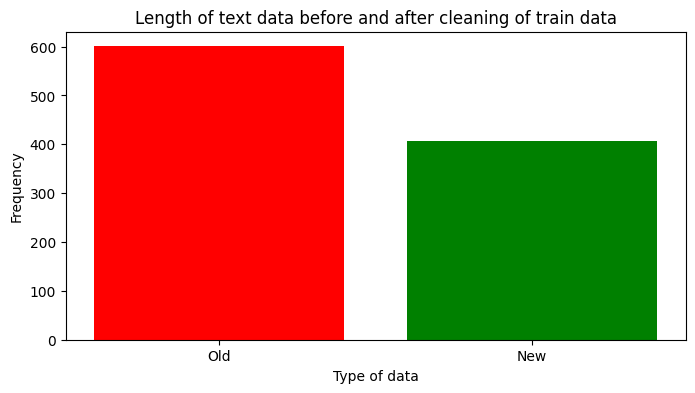

In [20]:
values = [length, cleaned_length]
labels = ['Old', 'New']

plt.figure(figsize=(8, 4))
plt.bar(labels, values, color=['red', 'green'])
plt.xlabel("Type of data")
plt.ylabel("Frequency")
plt.title("Length of text data before and after cleaning of train data")

plt.show()

In [21]:
# Balancing data over 2000 length because the avg of them is very less(appx. 401.9220...)
df_train["processed_plot"] = df_train["processed_plot"].apply(lambda x: x[:np.random.randint(250,2000)] if len(x)>2000 else x)

In [22]:
df_train['processed_plot'][0]

'listening conversation doctor parents year old oscar learns nobody courage tell weeks live furious refuses speak anyone except straight talking rose lady pink meets hospital stairs christmas approaches rose uses fantastical experiences professional wrestler imagination wit charm allow oscar live life love full company friends pop corn einstein bacon childhood sweetheart peggy blue'

In [23]:
labels_info = df_train['genre'].value_counts()
labels_info

genre
drama           13611
documentary     13093
comedy           7445
short            5072
horror           2203
thriller         1591
action           1315
western          1031
reality-tv        884
family            783
adventure         775
music             730
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           322
mystery           319
musical           277
biography         265
history           242
game-show         194
news              181
war               132
Name: count, dtype: int64

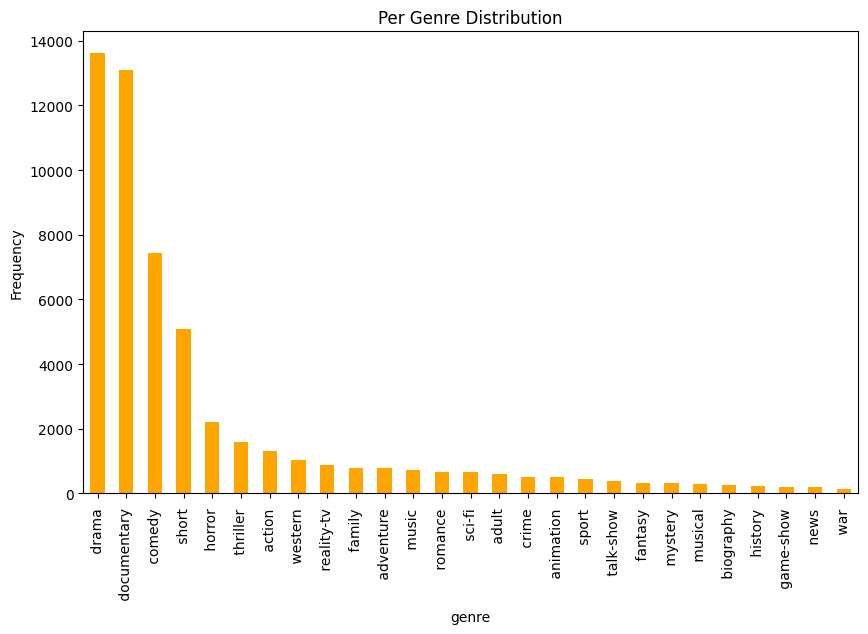

In [24]:
plt.figure(figsize=(10, 6))
labels_info.plot(kind='bar', color="orange")
plt.ylabel('Frequency')
plt.title("Per Genre Distribution")
plt.show()

**Merging movie_name and plot together**

In [25]:
df_train.head(2)

,movie_name,genre,plot,processed_plot
0,Oscar et la dame rose (2009),drama,"Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.",listening conversation doctor parents year old oscar learns nobody courage tell weeks live furious refuses speak anyone except straight talking rose lady pink meets hospital stairs christmas approaches rose uses fantastical experiences professional wrestler imagination wit charm allow oscar live life love full company friends pop corn einstein bacon childhood sweetheart peggy blue
1,Cupid (1997),thriller,A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.,brother sister past incestuous relationship current murderous relationship murders women reject murders women get close


In [26]:
df_train.drop(columns=['plot'], inplace=True)

In [27]:
df_test.drop(columns=['plot'], inplace=True)

In [28]:
df_train['input'] = df_train['movie_name'] + " " + df_train['processed_plot']
df_test['input'] = df_test['movie_name'] + " " + df_test['processed_plot']

In [29]:
df_train.sample()

,movie_name,genre,processed_plot,input
28263,Vierzehn (2012/I),documentary,lisa steffi laura fabienne pregnant naturally also teenagers schoolgirls children parents film accompanies emotional rollercoaster ride pregnancy childbirth right new life,Vierzehn (2012/I) lisa steffi laura fabienne pregnant naturally also teenagers schoolgirls children parents film accompanies emotional rollercoaster ride pregnancy childbirth right new life


# ALL DATA

In [30]:
all_text = pd.concat([df_train['input'], df_test['input']])

In [31]:
all_text.shape

(108400,)

In [32]:
tfdif = TfidfVectorizer(stop_words='english', max_features=35000)

In [33]:
tfdif.fit(all_text)

TfidfVectorizer(max_features=35000, stop_words='english')

In [34]:
X_train_vec = tfdif.transform(df_train['input'])
X_test_vec = tfdif.transform(df_train['input'])

**Encode the labels**

In [35]:

encoder = LabelEncoder()

y_train_enc = encoder.fit_transform(df_train['genre'])
y_test_enc = encoder.fit_transform(df_test['genre'])

**Randomizing the data**

In [36]:

sampler = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_vec, y_train_enc)

**Modeling**

In [37]:
mnb = MultinomialNB(alpha=0.5)
gnb = GaussianNB()
bnb = BernoulliNB()
lgc = LogisticRegression(solver="sag", C=0.5, max_iter=500, random_state=42, tol=0.1, n_jobs=4)
svc = LinearSVC()
rdmfr = RandomForestClassifier(n_estimators=100, random_state=42)
dcst = DecisionTreeClassifier()

In [38]:
lgc.fit(X_train_resampled, y_train_resampled)
lgc.score(X_test_vec, y_test_enc)

0.12835793357933578

In [41]:
svc.fit(X_train_resampled, y_train_resampled)
svc.score(X_test_vec, y_test_enc)

c:\Users\Aditya Lohia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.1528228782287823

In [ ]:
bnb.fit(X_train_resampled, y_train_resampled)
bnb.score(X_test_vec, y_test_enc)

0.1329520295202952

In [ ]:
mnb.fit(X_train_resampled, y_train_resampled)
mnb.score(X_test_vec, y_test_enc)

0.13062730627306274

0.13055350553505535

In [ ]:
ypred_test_lgc = lgc.predict(X_test_vec)
ypred_train_lgc = lgc.predict(X_train_resampled)

ypred_test_bnb = bnb.predict(X_test_vec)
ypred_train_bnb = bnb.predict(X_train_resampled)

ypred_test_mnb = mnb.predict(X_test_vec)
ypred_train_mnb = mnb.predict(X_train_resampled)

ypred_test_svc = svc.predict(X_test_vec)
ypred_train_svc = svc.predict(X_train_resampled)

In [ ]:

print("Logistic Regression : ")
print("Train accuracy: ", accuracy_score(y_train, ypred_train_lgc))
print("Test accuracy: ", accuracy_score(y_test, ypred_test_lgc))

print("\n\nBernoulliNB : ")
print("Train accuracy: ", accuracy_score(y_train, ypred_train_bnb))
print("Test accuracy: ", accuracy_score(y_test, ypred_test_bnb))

print("\n\nMultinomialNB : ")
print("Train accuracy: ", accuracy_score(y_train, ypred_train_mnb))
print("Test accuracy: ", accuracy_score(y_test, ypred_test_mnb))

print("\n\nSupport Vector : ")
print("Train accuracy: ", accuracy_score(y_train, ypred_train_svc))
print("Test accuracy: ", accuracy_score(y_test, ypred_test_svc))

Logistic Regression : 


NameError: name 'y_train' is not defined